# 1. Collision Detection Using Grover's Algorithm

1) Initializing the system:

In [112]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector
from qiskit import transpile

n = 3
solution = '101' #for bonus challenge, to generalise the problem

qc = QuantumCircuit(n, n)
qc.h(range(n))

2) The Oracle

In [113]:
def grover_oracle(n, solution):
    qc = QuantumCircuit(n)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1)  # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    for qubit, bit in enumerate(reversed(solution)):
        if bit == '0':
            qc.x(qubit)
    oracle_gate = qc.to_gate()
    oracle_gate.name = "Oracle"
    return oracle_gate

3) The Diffusion Operator 

In [114]:
def grover_diffuser(n):
    qc = QuantumCircuit(n)
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n - 1)
    qc.mcx(list(range(n - 1)), n - 1) # Multi-controlled X (Toffoli)
    qc.h(n - 1)
    qc.x(range(n))
    qc.h(range(n))
    diffuser_gate = qc.to_gate()
    diffuser_gate.name = "Diffuser"
    return diffuser_gate

4) Performing Grover interations

In [115]:
iterations = int(np.floor((np.pi*1.0) / 4 * np.sqrt(2**n)))

def grover_amplitudes(n, solution, iterations):
    sol_idx = int(solution, 2)

    oracle   = grover_oracle(n, solution)
    diffuser = grover_diffuser(n)

    sv = Statevector.from_label('0'*n)
    sv = sv.evolve(qc)

    amps = [abs(sv.data[sol_idx])]

    for _ in range(iterations):
        sv = sv.evolve(oracle)
        sv = sv.evolve(diffuser)
        amps.append(abs(sv.data[sol_idx]))

    return amps

def grover_counts(n,solution, iterations):

    oracle   = grover_oracle(n, solution)
    diffuser = grover_diffuser(n)

    for _ in range(iterations):
        qc.append(oracle,   range(n))
        qc.append(diffuser, range(n))
    qc.measure(range(n), range(n))                 

    backend = AerSimulator()
    shots = 2048

    transpiled_qc = transpile(qc, backend)

    result = backend.run(transpiled_qc, shots=shots).result()
    counts = result.get_counts(transpiled_qc)
    return counts

amps = grover_amplitudes(n, solution, iterations)
counts = grover_counts(n, solution, iterations)

5) Measuring the Final State

In [116]:
print(counts)

{'101': 1938, '111': 16, '110': 16, '011': 13, '001': 15, '100': 18, '010': 17, '000': 15}


6) Visualisation

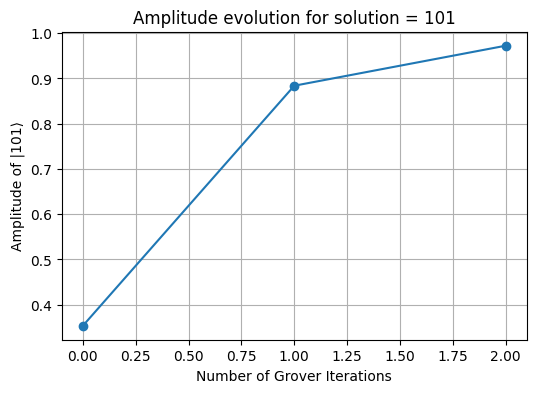

In [117]:
plt.figure(figsize=(6,4))
plt.plot(range(len(amps)), amps, 'o-')
plt.xlabel('Number of Grover Iterations')
plt.ylabel('Amplitude of |{}⟩'.format(solution))
plt.title(f'Amplitude evolution for solution = {solution}')
plt.grid(True)
plt.show()

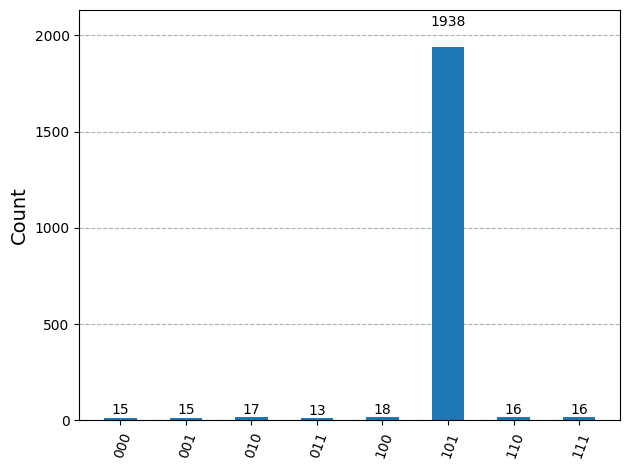

In [118]:
plot_histogram(counts)

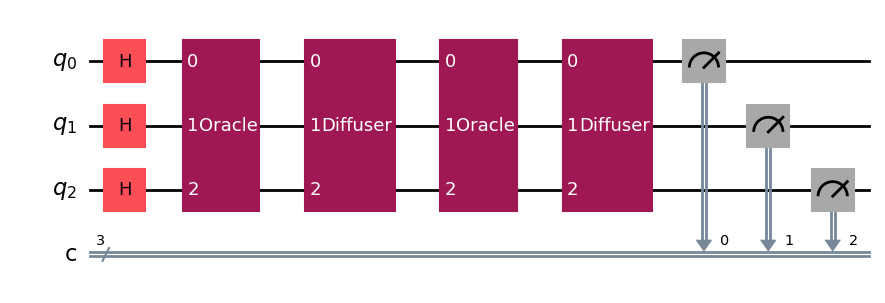

In [119]:
qc.draw('mpl')

# 2. Solving a 3-SAT Problem Using Grover's Algorithm